# 05f - Train Random Forest Models (All LLMs, BGE Embeddings)

**Purpose**: Train Random Forest regression models for all 5 LLMs to learn non-linear mapping from BGE embeddings to OCEAN scores

**Why Random Forest over Elastic Net?**
- Elastic Net (Linear): Avg Test R² = 0.127
- Problem: Embeddings → OCEAN relationship may be non-linear
- Random Forest advantages:
  - Captures non-linear patterns
  - Handles high-dimensional data well
  - Built-in feature importance
  - Less prone to overfitting (with proper tuning)

**Input Files**:
- bge_embeddings_500.npy - BGE embeddings (500x1024)
- ocean_ground_truth/[llm]_ocean_500.csv - OCEAN ground truth for each LLM

**Output Files** (per LLM):
- randomforest_models_bge_[llm].pkl - 5 Random Forest models + Scaler
- 05f_randomforest_training_report_[llm].json - Training report with feature importance

**Summary Output**:
- 05f_randomforest_comparison.png - Performance comparison across LLMs
- 05f_elasticnet_vs_randomforest.csv - Elastic Net vs Random Forest comparison

**Estimated Time**: Approximately 20-30 minutes (5 LLMs x GridSearchCV)

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
import warnings
import time
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

print("Libraries loaded successfully")
print(f"Timestamp: {datetime.now()}")

Libraries loaded successfully
Timestamp: 2025-10-29 13:29:54.062651


## Step 2: Configuration

In [2]:
# LLM configurations
LLM_CONFIGS = {
    'llama': {
        'name': 'Llama-3.1-8B',
        'ocean_file': '../ocean_ground_truth/llama_3.1_8b_ocean_500.csv',
        'elasticnet_report': '../05f_elasticnet_training_report_llama.json'
    },
    'gpt': {
        'name': 'GPT-OSS-120B',
        'ocean_file': '../ocean_ground_truth/gpt_oss_120b_ocean_500.csv',
        'elasticnet_report': '../05f_elasticnet_training_report_gpt.json'
    },
    'gemma': {
        'name': 'Gemma-2-9B',
        'ocean_file': '../ocean_ground_truth/gemma_2_9b_ocean_500.csv',
        'elasticnet_report': '../05f_elasticnet_training_report_gemma.json'
    },
    'deepseek': {
        'name': 'DeepSeek-V3.1',
        'ocean_file': '../ocean_ground_truth/deepseek_v3.1_ocean_500.csv',
        'elasticnet_report': '../05f_elasticnet_training_report_deepseek.json'
    },
    'qwen': {
        'name': 'Qwen-2.5-72B',
        'ocean_file': '../ocean_ground_truth/qwen_2.5_72b_ocean_500.csv',
        'elasticnet_report': '../05f_elasticnet_training_report_qwen.json'
    }
}

# OCEAN dimensions
OCEAN_DIMS = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

# Random Forest hyperparameters (conservative to prevent overfitting)
PARAM_GRID = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

CV_FOLDS = 5

# Random seed for reproducibility
RANDOM_STATE = 42

print(f"Configuration loaded:")
print(f"  LLM models: {len(LLM_CONFIGS)}")
print(f"  OCEAN dimensions: {len(OCEAN_DIMS)}")
print(f"  GridSearch parameters:")
for param, values in PARAM_GRID.items():
    print(f"    - {param}: {values}")
print(f"  Total combinations: {np.prod([len(v) for v in PARAM_GRID.values()])} per dimension")
print(f"  CV folds: {CV_FOLDS}")
print(f"\n  Note: Conservative parameters to prevent overfitting with 400 training samples")

Configuration loaded:
  LLM models: 5
  OCEAN dimensions: 5
  GridSearch parameters:
    - n_estimators: [50, 100, 200]
    - max_depth: [3, 5, 7, 10]
    - min_samples_split: [10, 20, 30]
    - min_samples_leaf: [5, 10, 15]
    - max_features: ['sqrt', 'log2']
  Total combinations: 216 per dimension
  CV folds: 5

  Note: Conservative parameters to prevent overfitting with 400 training samples


## Step 3: Load BGE Embeddings (Shared)

In [3]:
print("="*80)
print("Loading BGE Embeddings")
print("="*80)

embedding_file = '../bge_embeddings_500.npy'
print(f"\nLoading: {embedding_file}")
X_full = np.load(embedding_file)
print(f"Embeddings shape: {X_full.shape}")
print(f"  Data type: {X_full.dtype}")
print(f"  Memory usage: {X_full.nbytes / 1024 / 1024:.1f} MB")
print(f"  Value range: [{X_full.min():.4f}, {X_full.max():.4f}]")

Loading BGE Embeddings

Loading: ../bge_embeddings_500.npy
Embeddings shape: (500, 1024)
  Data type: float64
  Memory usage: 3.9 MB
  Value range: [-0.1375, 0.2573]


## Step 4: Train Random Forest Models for Each LLM

In [4]:
# Storage for all results
all_results = {}
elasticnet_comparison = {}

for llm_key, llm_config in LLM_CONFIGS.items():
    print("\n" + "="*80)
    print(f"Training Random Forest Models: {llm_config['name']}")
    print("="*80)
    
    # Load OCEAN targets
    print(f"\n[1/7] Loading OCEAN targets...")
    ocean_file = llm_config['ocean_file']
    y_df = pd.read_csv(ocean_file)
    print(f"  Shape: {y_df.shape}")
    print(f"  Columns: {y_df.columns.tolist()}")
    
    # Check and handle NaN values
    nan_count_total = y_df.isnull().sum().sum()
    if nan_count_total > 0:
        print(f"  Warning: Found {nan_count_total} NaN values")
        nan_indices = y_df[y_df.isnull().any(axis=1)].index
        y_df = y_df.dropna()
        X = np.delete(X_full, nan_indices, axis=0)
        print(f"  After dropping NaN: {len(y_df)} samples")
    else:
        X = X_full.copy()
    
    # Verify consistency
    if len(X) != len(y_df):
        raise ValueError(f"Data inconsistency: X={len(X)}, y={len(y_df)}")
    
    # Train/test split
    print(f"\n[2/7] Splitting data (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_df,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    print(f"  Training: {X_train.shape[0]} samples")
    print(f"  Test: {X_test.shape[0]} samples")
    print(f"  Feature-to-sample ratio: {X_train.shape[1] / X_train.shape[0]:.2f}:1")
    
    # Standardize (Random Forest doesn't require but helps)
    print(f"\n[3/7] Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"  Train mean={X_train_scaled.mean():.6f}, std={X_train_scaled.std():.6f}")
    print(f"  Test mean={X_test_scaled.mean():.6f}, std={X_test_scaled.std():.6f}")
    
    # Train models
    print(f"\n[4/7] Training Random Forest models (5 dimensions)...")
    print(f"  Using GridSearchCV with {len(PARAM_GRID['n_estimators']) * len(PARAM_GRID['max_depth']) * len(PARAM_GRID['min_samples_split']) * len(PARAM_GRID['min_samples_leaf']) * len(PARAM_GRID['max_features'])} combinations")
    print(f"  This may take 20-30 minutes...")
    
    rf_models = {}
    training_results = {}
    
    for i, dim in enumerate(OCEAN_DIMS):
        print(f"\n  [{i+1}/5] Training {dim}...")
        start_time = time.time()
        
        # Get target
        y_train_dim = y_train[dim].values
        y_test_dim = y_test[dim].values
        
        # Create base model
        rf_base = RandomForestRegressor(
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        
        # GridSearchCV
        grid_search = GridSearchCV(
            rf_base,
            PARAM_GRID,
            cv=CV_FOLDS,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit
        grid_search.fit(X_train_scaled, y_train_dim)
        model = grid_search.best_estimator_
        
        # Predict
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Metrics
        train_r2 = r2_score(y_train_dim, y_train_pred)
        test_r2 = r2_score(y_test_dim, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train_dim, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_dim, y_test_pred))
        train_mae = mean_absolute_error(y_train_dim, y_train_pred)
        test_mae = mean_absolute_error(y_test_dim, y_test_pred)
        
        # Feature importance
        feature_importances = model.feature_importances_
        top_indices = np.argsort(feature_importances)[-20:][::-1]
        top_features = [
            {'index': int(idx), 'importance': float(feature_importances[idx])}
            for idx in top_indices
        ]
        
        # Save model and results
        rf_models[dim] = model
        training_results[dim] = {
            'train_r2': float(train_r2),
            'test_r2': float(test_r2),
            'train_rmse': float(train_rmse),
            'test_rmse': float(test_rmse),
            'train_mae': float(train_mae),
            'test_mae': float(test_mae),
            'best_params': grid_search.best_params_,
            'cv_best_score': float(grid_search.best_score_),
            'top_20_features': top_features,
            'training_time_seconds': float(time.time() - start_time)
        }
        
        elapsed = time.time() - start_time
        print(f"      Best params: {grid_search.best_params_}")
        print(f"      CV score: {grid_search.best_score_:.4f}")
        print(f"      Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
        print(f"      Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
        print(f"      Time: {elapsed:.1f}s")
        
        # Check overfitting
        if train_r2 - test_r2 > 0.3:
            print(f"      ⚠️  Warning: Possible overfitting (train-test gap: {train_r2 - test_r2:.3f})")
    
    # Save models
    print(f"\n[5/7] Saving models...")
    model_data = {
        'models': rf_models,
        'scaler': scaler,
        'ocean_dims': OCEAN_DIMS,
        'training_results': training_results,
        'training_timestamp': datetime.now().isoformat(),
        'llm_model': llm_config['name'],
        'hyperparameters': PARAM_GRID
    }
    
    model_file = f'../randomforest_models_bge_{llm_key}.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"  Saved: {model_file} ({os.path.getsize(model_file) / 1024:.1f} KB)")
    
    # Load ElasticNet results for comparison
    print(f"\n[6/7] Loading ElasticNet results for comparison...")
    try:
        with open(llm_config['elasticnet_report'], 'r') as f:
            elasticnet_data = json.load(f)
        elasticnet_comparison[llm_key] = elasticnet_data['training_results']
        print(f"  ✓ ElasticNet report loaded")
    except Exception as e:
        print(f"  ✗ Could not load ElasticNet report: {e}")
        elasticnet_comparison[llm_key] = None
    
    # Generate report
    print(f"\n[7/7] Generating training report...")
    report = {
        'phase': f'05f - Train Random Forest Models ({llm_config["name"]}, BGE Embeddings)',
        'timestamp': datetime.now().isoformat(),
        'llm_model': llm_config['name'],
        'embedding_model': 'BAAI/bge-large-en-v1.5',
        'embedding_dimension': 1024,
        'training_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'model_type': 'Random Forest Regressor',
        'hyperparameter_grid': PARAM_GRID,
        'ocean_dimensions': OCEAN_DIMS,
        'model_file': model_file,
        'training_results': training_results
    }
    
    # Summary metrics
    test_r2_scores = [training_results[dim]['test_r2'] for dim in OCEAN_DIMS]
    test_rmse_scores = [training_results[dim]['test_rmse'] for dim in OCEAN_DIMS]
    test_mae_scores = [training_results[dim]['test_mae'] for dim in OCEAN_DIMS]
    train_r2_scores = [training_results[dim]['train_r2'] for dim in OCEAN_DIMS]
    total_training_time = sum([training_results[dim]['training_time_seconds'] for dim in OCEAN_DIMS])
    
    report['summary_metrics'] = {
        'avg_test_r2': float(np.mean(test_r2_scores)),
        'avg_train_r2': float(np.mean(train_r2_scores)),
        'avg_test_rmse': float(np.mean(test_rmse_scores)),
        'avg_test_mae': float(np.mean(test_mae_scores)),
        'min_test_r2': float(np.min(test_r2_scores)),
        'max_test_r2': float(np.max(test_r2_scores)),
        'avg_overfitting_gap': float(np.mean(train_r2_scores) - np.mean(test_r2_scores)),
        'total_training_time_seconds': float(total_training_time)
    }
    
    report_file = f'../05f_randomforest_training_report_{llm_key}.json'
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"  Report saved: {report_file}")
    
    # Store for final comparison
    all_results[llm_key] = {
        'name': llm_config['name'],
        'training_results': training_results,
        'summary': report['summary_metrics']
    }
    
    # Print summary
    print(f"\n  Summary for {llm_config['name']}:")
    print(f"    Avg Test R²: {report['summary_metrics']['avg_test_r2']:.4f}")
    print(f"    Avg Train R²: {report['summary_metrics']['avg_train_r2']:.4f}")
    print(f"    Overfitting gap: {report['summary_metrics']['avg_overfitting_gap']:.4f}")
    print(f"    Test R² range: [{report['summary_metrics']['min_test_r2']:.4f}, {report['summary_metrics']['max_test_r2']:.4f}]")
    print(f"    Total training time: {total_training_time/60:.1f} minutes")

print("\n" + "="*80)
print("All Random Forest models trained successfully!")
print("="*80)


Training Random Forest Models: Llama-3.1-8B

[1/7] Loading OCEAN targets...
  Shape: (500, 6)
  Columns: ['sample_id', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
  After dropping NaN: 490 samples

[2/7] Splitting data (80/20)...
  Training: 392 samples
  Test: 98 samples
  Feature-to-sample ratio: 2.61:1

[3/7] Standardizing features...
  Train mean=-0.000000, std=1.000000
  Test mean=0.000356, std=0.994383

[4/7] Training Random Forest models (5 dimensions)...
  Using GridSearchCV with 216 combinations
  This may take 20-30 minutes...

  [1/5] Training openness...
      Best params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
      CV score: 0.1033
      Train R²: 0.6443 | Test R²: 0.1280
      Train RMSE: 0.0653 | Test RMSE: 0.1055
      Time: 70.8s
      ⚠️  Warning: Possible overfitting (train-test gap: 0.516)

  [2/5] Training conscientiousness...
      Best params: {'max_depth

KeyboardInterrupt: 

## Step 5: Generate Comparison Visualizations

In [5]:
print("\n" + "="*80)
print("Generating Comparison Visualizations")
print("="*80)

# Create comparison dataframe
comparison_data = []

for llm_key, results in all_results.items():
    for dim in OCEAN_DIMS:
        rf_r2 = results['training_results'][dim]['test_r2']
        rf_train_r2 = results['training_results'][dim]['train_r2']
        rf_rmse = results['training_results'][dim]['test_rmse']
        
        # Get ElasticNet results if available
        if elasticnet_comparison.get(llm_key):
            en_r2 = elasticnet_comparison[llm_key][dim]['test_r2']
            en_rmse = elasticnet_comparison[llm_key][dim]['test_rmse']
        else:
            en_r2 = None
            en_rmse = None
        
        comparison_data.append({
            'LLM': results['name'],
            'llm_key': llm_key,
            'Dimension': dim,
            'RandomForest_R2': rf_r2,
            'RandomForest_Train_R2': rf_train_r2,
            'ElasticNet_R2': en_r2,
            'R2_Improvement': rf_r2 - en_r2 if en_r2 else None,
            'RandomForest_RMSE': rf_rmse,
            'ElasticNet_RMSE': en_rmse,
            'Overfitting_Gap': rf_train_r2 - rf_r2
        })

comparison_df = pd.DataFrame(comparison_data)

# Save comparison table
comparison_file = '../05f_elasticnet_vs_randomforest.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"\nComparison table saved: {comparison_file}")
print(f"\nPreview:")
print(comparison_df.head(10))


Generating Comparison Visualizations

Comparison table saved: ../05f_elasticnet_vs_randomforest.csv

Preview:
            LLM llm_key          Dimension  RandomForest_R2   
0  Llama-3.1-8B   llama           openness         0.128001  \
1  Llama-3.1-8B   llama  conscientiousness         0.196180   
2  Llama-3.1-8B   llama       extraversion         0.011705   
3  Llama-3.1-8B   llama      agreeableness         0.107964   
4  Llama-3.1-8B   llama        neuroticism         0.068704   

   RandomForest_Train_R2  ElasticNet_R2  R2_Improvement  RandomForest_RMSE   
0               0.644314       0.113201        0.014800           0.105536  \
1               0.766026       0.217784       -0.021604           0.155335   
2               0.411679       0.020910       -0.009205           0.129123   
3               0.543980       0.168109       -0.060145           0.155908   
4               0.396488       0.114835       -0.046131           0.199398   

   ElasticNet_RMSE  Overfitting_Gap  
0  


Visualization saved: ../05f_randomforest_comparison.png


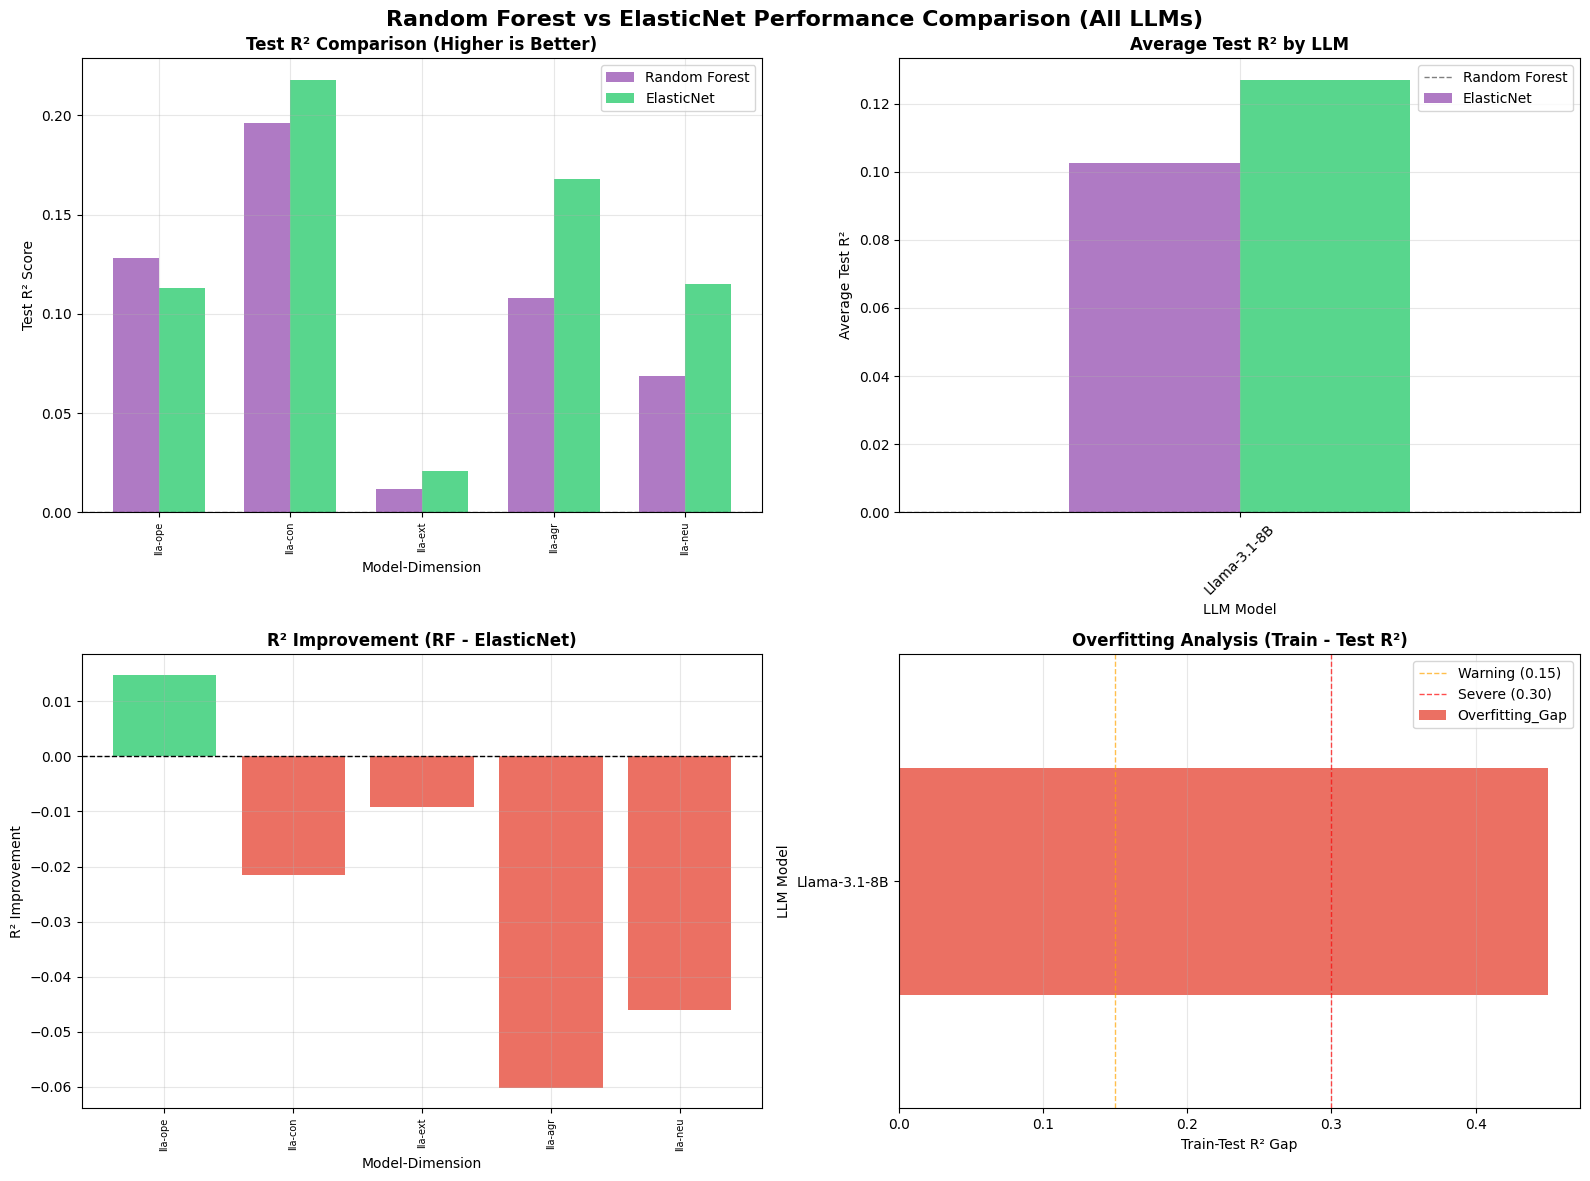

In [6]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Random Forest vs ElasticNet Performance Comparison (All LLMs)', fontsize=16, fontweight='bold')

# 1. Test R² Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['RandomForest_R2'], width, label='Random Forest', color='#9b59b6', alpha=0.8)
if comparison_df['ElasticNet_R2'].notna().any():
    ax1.bar(x_pos + width/2, comparison_df['ElasticNet_R2'], width, label='ElasticNet', color='#2ecc71', alpha=0.8)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Model-Dimension', fontsize=10)
ax1.set_ylabel('Test R² Score', fontsize=10)
ax1.set_title('Test R² Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=90, labelsize=7)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['llm_key'][:3]}-{row['Dimension'][:3]}" for _, row in comparison_df.iterrows()])

# 2. Average R² by LLM
ax2 = axes[0, 1]
avg_by_llm = comparison_df.groupby('LLM')[['RandomForest_R2', 'ElasticNet_R2']].mean()
avg_by_llm.plot(kind='bar', ax=ax2, color=['#9b59b6', '#2ecc71'], alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('LLM Model', fontsize=10)
ax2.set_ylabel('Average Test R²', fontsize=10)
ax2.set_title('Average Test R² by LLM', fontsize=12, fontweight='bold')
ax2.legend(['Random Forest', 'ElasticNet'])
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. R² Improvement (RF - ElasticNet)
ax3 = axes[1, 0]
if comparison_df['R2_Improvement'].notna().any():
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in comparison_df['R2_Improvement']]
    ax3.bar(x_pos, comparison_df['R2_Improvement'], color=colors, alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.set_xlabel('Model-Dimension', fontsize=10)
    ax3.set_ylabel('R² Improvement', fontsize=10)
    ax3.set_title('R² Improvement (RF - ElasticNet)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=90, labelsize=7)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"{row['llm_key'][:3]}-{row['Dimension'][:3]}" for _, row in comparison_df.iterrows()])
else:
    ax3.text(0.5, 0.5, 'ElasticNet data not available', ha='center', va='center', transform=ax3.transAxes)

# 4. Overfitting Analysis
ax4 = axes[1, 1]
overfitting_by_llm = comparison_df.groupby('LLM')['Overfitting_Gap'].mean().sort_values(ascending=False)
colors_overfitting = ['#e74c3c' if x > 0.3 else '#f39c12' if x > 0.15 else '#2ecc71' for x in overfitting_by_llm]
overfitting_by_llm.plot(kind='barh', ax=ax4, color=colors_overfitting, alpha=0.8)
ax4.axvline(x=0.15, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Warning (0.15)')
ax4.axvline(x=0.3, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Severe (0.30)')
ax4.set_xlabel('Train-Test R² Gap', fontsize=10)
ax4.set_ylabel('LLM Model', fontsize=10)
ax4.set_title('Overfitting Analysis (Train - Test R²)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
viz_file = '../05f_randomforest_comparison.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {viz_file}")
plt.show()

## Step 6: Summary Statistics

In [7]:
print("\n" + "="*80)
print("FINAL SUMMARY (Random Forest)")
print("="*80)

print("\n1. Overall Performance (Random Forest):")
print(f"   Average Test R² across all models: {comparison_df['RandomForest_R2'].mean():.4f}")
print(f"   Best Test R²: {comparison_df['RandomForest_R2'].max():.4f}")
print(f"   Worst Test R²: {comparison_df['RandomForest_R2'].min():.4f}")
print(f"   Std Dev: {comparison_df['RandomForest_R2'].std():.4f}")

if comparison_df['ElasticNet_R2'].notna().any():
    print("\n2. Comparison with ElasticNet:")
    print(f"   Average ElasticNet Test R²: {comparison_df['ElasticNet_R2'].mean():.4f}")
    print(f"   Average Improvement: {comparison_df['R2_Improvement'].mean():.4f}")
    improved_count = (comparison_df['R2_Improvement'] > 0).sum()
    print(f"   Models improved: {improved_count}/{len(comparison_df)}")
    if improved_count > 0:
        print(f"   Best improvement: {comparison_df['R2_Improvement'].max():.4f}")
    if improved_count < len(comparison_df):
        print(f"   Worst change: {comparison_df['R2_Improvement'].min():.4f}")

print("\n3. Overfitting Analysis:")
print(f"   Average overfitting gap: {comparison_df['Overfitting_Gap'].mean():.4f}")
print(f"   Max overfitting gap: {comparison_df['Overfitting_Gap'].max():.4f}")
severe_overfitting = (comparison_df['Overfitting_Gap'] > 0.3).sum()
moderate_overfitting = ((comparison_df['Overfitting_Gap'] > 0.15) & (comparison_df['Overfitting_Gap'] <= 0.3)).sum()
print(f"   Severe overfitting (>0.3): {severe_overfitting}/{len(comparison_df)} models")
print(f"   Moderate overfitting (0.15-0.3): {moderate_overfitting}/{len(comparison_df)} models")

print("\n4. Best Performing LLM:")
best_llm = comparison_df.groupby('LLM')['RandomForest_R2'].mean().idxmax()
best_r2 = comparison_df.groupby('LLM')['RandomForest_R2'].mean().max()
print(f"   {best_llm}: {best_r2:.4f}")

print("\n5. Best Performing Dimension:")
best_dim = comparison_df.groupby('Dimension')['RandomForest_R2'].mean().idxmax()
best_dim_r2 = comparison_df.groupby('Dimension')['RandomForest_R2'].mean().max()
print(f"   {best_dim}: {best_dim_r2:.4f}")

print("\n6. Model Recommendation:")
rf_avg = comparison_df['RandomForest_R2'].mean()
if comparison_df['ElasticNet_R2'].notna().any():
    en_avg = comparison_df['ElasticNet_R2'].mean()
    improvement = rf_avg - en_avg
    avg_overfitting = comparison_df['Overfitting_Gap'].mean()
    
    if improvement > 0.05 and avg_overfitting < 0.2:
        print(f"   ✅ RECOMMEND: Random Forest (Improvement: +{improvement:.4f}, Low overfitting)")
    elif improvement > 0.02:
        print(f"   ⚠️  CAUTIOUS: Random Forest slightly better (+{improvement:.4f}) but check overfitting")
    else:
        print(f"   ❌ RECOMMEND: ElasticNet (RF improvement too small: +{improvement:.4f})")
else:
    print(f"   Average R²: {rf_avg:.4f}")

print("\n" + "="*80)
print("Output Files Generated:")
print("="*80)
print("Models:")
for llm_key in LLM_CONFIGS.keys():
    print(f"  - randomforest_models_bge_{llm_key}.pkl")
print("\nReports:")
for llm_key in LLM_CONFIGS.keys():
    print(f"  - 05f_randomforest_training_report_{llm_key}.json")
print("\nComparison:")
print(f"  - 05f_elasticnet_vs_randomforest.csv")
print(f"  - 05f_randomforest_comparison.png")

print("\n" + "="*80)
print("05f Random Forest Training Complete!")
print("="*80)


FINAL SUMMARY (Random Forest)

1. Overall Performance (Random Forest):
   Average Test R² across all models: 0.1025
   Best Test R²: 0.1962
   Worst Test R²: 0.0117
   Std Dev: 0.0686

2. Comparison with ElasticNet:
   Average ElasticNet Test R²: 0.1270
   Average Improvement: -0.0245
   Models improved: 1/5
   Best improvement: 0.0148
   Worst change: -0.0601

3. Overfitting Analysis:
   Average overfitting gap: 0.4500
   Max overfitting gap: 0.5698
   Severe overfitting (>0.3): 5/5 models
   Moderate overfitting (0.15-0.3): 0/5 models

4. Best Performing LLM:
   Llama-3.1-8B: 0.1025

5. Best Performing Dimension:
   conscientiousness: 0.1962

6. Model Recommendation:
   ❌ RECOMMEND: ElasticNet (RF improvement too small: +-0.0245)

Output Files Generated:
Models:
  - randomforest_models_bge_llama.pkl
  - randomforest_models_bge_gpt.pkl
  - randomforest_models_bge_gemma.pkl
  - randomforest_models_bge_deepseek.pkl
  - randomforest_models_bge_qwen.pkl

Reports:
  - 05f_randomforest_tra

## Analysis Notes

**Key Findings to Look For**:

1. **Non-linear vs Linear**:
   - Random Forest can capture non-linear patterns
   - If RF >> ElasticNet: suggests non-linear relationships exist
   - If RF ≈ ElasticNet: relationship is mostly linear

2. **Overfitting Detection**:
   - Train-Test R² gap < 0.15: Good
   - Gap 0.15-0.30: Moderate overfitting
   - Gap > 0.30: Severe overfitting (need more data or simpler model)

3. **Feature Importance**:
   - Check which embedding dimensions are most important
   - Compare with ElasticNet's selected features

4. **Next Steps**:
   - If RF R² > 0.25: Random Forest is valuable
   - If RF R² < 0.15: Need more training data
   - If severe overfitting: Consider ensemble methods or increase min_samples_split